In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from census_utils import *
import matplotlib.pyplot as plt
import statsmodels.api as sm
from geopy import distance
from shapely.geometry import LineString

# Data Processing
## Load synthetic data

In [2]:
DEMO_COLS = ['TOTAL', 'W', 'B', 'AI_AN', 'AS', 'H_PI', 'OTH', 'TWO_OR_MORE', 'NUM_HISP', '18_PLUS']

In [3]:
synth_df = pd.read_csv(get_synthetic_out_file())
synth_df.head()

,YEAR,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,TRACTA,BLKGRPA,BLOCKA,NAME,...,AS,H_PI,OTH,TWO_OR_MORE,NUM_HISP,18_PLUS,HH_NUM,ACCURACY,AGE_ACCURACY,identifier
0,2010,Georgia,13,Appling County,1,90078,950100,1,1005,Block 1005,...,0,0,0,0,0,1,0,1,True,19501001005
1,2010,Georgia,13,Appling County,1,90078,950100,1,1005,Block 1005,...,0,0,0,0,0,1,1,1,True,19501001005
2,2010,Georgia,13,Appling County,1,90078,950100,1,1005,Block 1005,...,0,0,0,0,0,1,2,1,True,19501001005
3,2010,Georgia,13,Appling County,1,90078,950100,1,1005,Block 1005,...,0,0,0,0,0,1,3,1,True,19501001005
4,2010,Georgia,13,Appling County,1,90078,950100,1,1005,Block 1005,...,0,0,0,0,0,1,4,1,True,19501001005


In [4]:
swapped_df = pd.read_csv(get_swapped_file())
swapped_df.rename(columns={'county': 'COUNTYA', 'tract': 'TRACTA', 'X18_PLUS': '18_PLUS'}, inplace=True)
swapped_df.head()

,Unnamed: 0,YEAR,STATE,STATEA,COUNTYA,TRACTA,BLOCKA,BLOCK_TOTAL,BLOCK_18_PLUS,TOTAL,...,TWO_OR_MORE,NUM_HISP,18_PLUS,HH_NUM,frequency,U,prob,blockid,household.id,swapped
0,0,2010,Georgia,13,153,21400,1040,1,1,1,...,0,1,1,0,102,4,1.0,021400-153-1034,021400-153-1040-0001,1
1,1,2010,Georgia,13,299,950200,3024,1,1,1,...,0,1,1,0,102,4,1.0,950200-299-3025,950200-299-3024-0000,1
2,2,2010,Georgia,13,23,790100,1101,1,1,1,...,0,0,1,0,268,4,1.0,790100-023-1102,790100-023-1101-0001,1
3,3,2010,Georgia,13,207,50102,2018,1,1,1,...,0,0,1,0,268,4,1.0,150100-035-4082,050102-207-2018-0001,1
4,4,2010,Georgia,13,63,40412,3020,1,1,1,...,0,0,1,0,268,4,1.0,040412-063-3031,040412-063-3020-0003,1


## Join the two together
For the swapped data, `household.id` countains the destination block and `blockid` contains the source block

In [5]:
ID_COLS = ['TRACTA', 'COUNTYA', 'BLOCKA']
def make_identifier_synth(df):
    id_lens = [6, 3, 4]
    str_cols = [col + '_str' for col in ID_COLS]
    for col, l, col_s in zip(ID_COLS, id_lens, str_cols):
        assert max(num_digits(s) for s in df[col].unique()) <= l
        df[col_s] = df[col].astype(str).str.zfill(l)
    df['id'] = df[str_cols].astype(str).agg('-'.join, axis=1)
    for col_s in str_cols:
        del df[col_s]
        
def make_identifier_swapped(df):
    df['id'] = df['household.id'].str.replace('-[0-9]+$', '')

In [6]:
make_identifier_synth(synth_df)
make_identifier_swapped(swapped_df)

/var/folders/8_/y856fj8d3fx5mhg4ch9grjd80000gn/T/ipykernel_85592/4037533128.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['id'] = df['household.id'].str.replace('-[0-9]+$', '')


In [7]:
def aggregate_to_block_synth(df):
    demo_cols = ['TOTAL', 'W', 'B', 'AI_AN', 'AS', 'H_PI', 'OTH', 'TWO_OR_MORE', 'NUM_HISP', '18_PLUS']
    agg_dict = {col : np.sum for col in demo_cols}
    agg_dict['AGE_ACCURACY'] = np.mean
    agg_dict['ACCURACY'] = np.mean
    df['NUM_HH'] = np.ones(len(df))
    agg_dict['NUM_HH'] = 'count'
    agg_df = df.groupby(['id', 'COUNTYA', 'TRACTA', 'BLOCKA']).agg(agg_dict).reset_index()
    return agg_df

def aggregate_to_block_swapped(df):
    demo_cols = ['TOTAL', 'W', 'B', 'AI_AN', 'AS', 'H_PI', 'OTH', 'TWO_OR_MORE', 'NUM_HISP', '18_PLUS']
    agg_dict = {col : np.sum for col in demo_cols}
    agg_dict['swapped'] = np.sum
    agg_df = df.groupby(['id']).agg(agg_dict).reset_index()
    return agg_df

In [8]:
synth_agg = aggregate_to_block_synth(synth_df)
print(len(synth_agg))
synth_agg.head()

167353


,id,COUNTYA,TRACTA,BLOCKA,TOTAL,W,B,AI_AN,AS,H_PI,OTH,TWO_OR_MORE,NUM_HISP,18_PLUS,AGE_ACCURACY,ACCURACY,NUM_HH
0,000100-051-1001,51,100,1001,2,0,2,0,0,0,0,0,2,2,0.0,3.0,2
1,000100-051-1012,51,100,1012,88,1,87,0,0,0,0,0,0,38,1.0,1.0,33
2,000100-051-1013,51,100,1013,22,0,18,0,0,0,0,4,4,9,1.0,1.0,8
3,000100-051-1018,51,100,1018,16,0,16,0,0,0,0,0,0,8,1.0,1.0,5
4,000100-051-1028,51,100,1028,329,251,42,0,17,1,9,9,37,184,0.0,3.0,63


In [9]:
swapped_agg = aggregate_to_block_swapped(swapped_df)
print(len(swapped_agg))
swapped_agg.head()

167353


,id,TOTAL,W,B,AI_AN,AS,H_PI,OTH,TWO_OR_MORE,NUM_HISP,18_PLUS,swapped
0,000100-051-1001,2,0,2,0,0,0,0,0,0,2,2
1,000100-051-1012,88,1,87,0,0,0,0,0,1,38,1
2,000100-051-1013,22,0,18,0,0,0,0,4,5,9,1
3,000100-051-1018,16,0,16,0,0,0,0,0,0,8,0
4,000100-051-1028,329,251,42,0,17,1,9,9,37,184,0


In [10]:
def merge_synth_swapped(synth_agg, swapped_agg):
    df = synth_agg.merge(swapped_agg,
                        how='inner',
                        on='id',
                        suffixes=('_sy', '_sw'),
                        validate='one_to_one')
    return df

## Load map data

In [11]:
def load_shape_data(area):
    block_map = gpd.read_file(get_shape_file(area))
    return block_map.to_crs("EPSG:3395")

In [16]:
maps = {area: load_shape_data(area) for area in get_shape_file.AREAS}

In [13]:
maps = {'LOW_LEG': load_shape_data('LOW_LEG')}
maps['BLOCK'] = load_shape_data('BLOCK')

In [14]:
block_map = maps['BLOCK']
statefp = block_map['STATEFP10'].unique()[0]

In [15]:
for area, m in maps.items():
    if area not in ['BLOCK', 'BLOCK_GROUP']:
        m.drop(m[m['STATEFP10'] != statefp].index, inplace=True)

In [16]:
block_map.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,GISJOIN,Shape_area,Shape_len,geometry
0,13,007,960100,2050,130079601002050,Block 2050,G5040,R,None,None,S,612528,0,+31.3277979,-084.4160009,G13000709601002050,6.125277e+05,3715.902259,"POLYGON ((-9396469.535 3653263.291, -9396474.0..."
1,13,007,960100,1149,130079601001149,Block 1149,G5040,R,None,None,S,5854,0,+31.3484357,-084.3074734,G13000709601001149,5.853541e+03,702.869588,"POLYGON ((-9384854.459 3655836.851, -9384949.0..."
2,13,007,960100,1209,130079601001209,Block 1209,G5040,R,None,None,S,3861,0,+31.3689730,-084.2441048,G13000709601001209,3.860879e+03,312.937685,"POLYGON ((-9377961.000 3658476.737, -9377972.6..."
3,13,007,960100,1088,130079601001088,Block 1088,G5040,R,None,None,S,12284613,46705,+31.3869852,-084.3178991,G13000709601001088,1.233132e+07,20396.775829,"POLYGON ((-9385835.963 3656145.176, -9386135.9..."
4,13,007,960100,1163,130079601001163,Block 1163,G5040,R,None,None,S,781861,7655,+31.4169671,-084.2312666,G13000709601001163,7.895162e+05,3865.045979,"POLYGON ((-9375959.921 3665128.695, -9375969.7..."


In [17]:
maps['LOW_LEG'].head()

,STATEFP10,SLDLST10,GEOID10,NAMELSAD10,LSAD10,LSY10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,GISJOIN,Shape_area,Shape_len,geometry
827,13,002,13002,State House District 2,LL,2010,G5220,N,1249280160,1266269,+34.7704331,-085.3865767,G130002,1.250546e+09,243056.401111,"POLYGON ((-9480908.263 4101589.015, -9480886.3..."
828,13,158,13158,State House District 158,LL,2010,G5220,N,1861068855,28241802,+32.2323599,-081.6008794,G130158,1.889311e+09,309628.194894,"POLYGON ((-9067003.583 3779586.204, -9066978.0..."
829,13,164,13164,State House District 164,LL,2010,G5220,N,690913871,251589998,+31.8405630,-081.2072399,G130164,7.435223e+08,347700.223305,"MULTIPOLYGON (((-9036886.318 3704655.009, -903..."
830,13,168,13168,State House District 168,LL,2010,G5220,N,2803992245,97376105,+31.7065542,-082.3422303,G130168,2.901368e+09,337427.381431,"POLYGON ((-9153249.806 3729320.191, -9153239.0..."
831,13,177,13177,State House District 177,LL,2010,G5220,N,4315015775,63001608,+30.9199981,-082.3567036,G130177,4.378024e+09,461506.104024,"POLYGON ((-9174645.857 3664768.998, -9174652.4..."


In [27]:
def make_GISJOIN(df):
    block_df = pd.read_csv(get_block_file())
    block_df = block_df[['GISJOIN', 'COUNTYA', 'TRACTA', 'BLOCKA', 'SLDUA', 'SLDLA', 'CDA']]
    return df.merge(block_df,
             how='inner',
             on=['COUNTYA', 'TRACTA', 'BLOCKA'],
             validate='one_to_one')

def cols_to_str(df):
    df['COUNTYFP10'] = df['COUNTYA'].astype(str).str.zfill(3)
    df['TRACTCE10'] = df['TRACTA'].astype(str).str.zfill(6)
    df['BLOCKCE10'] = df['BLOCKA'].astype(str).str.zfill(4)
    df['CD111FP'] = df['CDA'].astype(str).str.zfill(2)
    df['SLDLA'] = df['SLDLA'].astype(str).str.zfill(3)

In [28]:
orig_df = merge_synth_swapped(synth_agg, swapped_agg)
orig_df = make_GISJOIN(orig_df)
cols_to_str(orig_df)

In [20]:
orig_df.head()

,id,COUNTYA,TRACTA,BLOCKA,TOTAL_sy,W_sy,B_sy,AI_AN_sy,AS_sy,H_PI_sy,...,18_PLUS_sw,swapped,GISJOIN,SLDUA,SLDLA,CDA,COUNTYFP10,TRACTCE10,BLOCKCE10,CD111FP
0,000100-051-1001,51,100,1001,2,0,2,0,0,0,...,2,2,G13005100001001001,2,160,12,051,000100,1001,12
1,000100-051-1012,51,100,1012,88,1,87,0,0,0,...,38,1,G13005100001001012,2,160,12,051,000100,1012,12
2,000100-051-1013,51,100,1013,22,0,18,0,0,0,...,9,1,G13005100001001013,2,160,12,051,000100,1013,12
3,000100-051-1018,51,100,1018,16,0,16,0,0,0,...,8,0,G13005100001001018,2,160,12,051,000100,1018,12
4,000100-051-1028,51,100,1028,329,251,42,0,17,1,...,184,0,G13005100001001028,2,160,12,051,000100,1028,12


In [21]:
def get_aggregated_df(df, col):
    demo_cols = ['TOTAL', 'W', 'B', 'AI_AN', 'AS', 'H_PI', 'OTH', 'TWO_OR_MORE', 'NUM_HISP', '18_PLUS']
    agg_dict = {col + '_sw' : np.sum for col in demo_cols}
    agg_dict['swapped'] = np.sum
    agg_dict['NUM_HH'] = np.sum
    agg_dict.update({col + '_sy' : np.sum for col in demo_cols})
    return df.groupby(col).agg(agg_dict)

In [22]:
def get_geo_at_area(area):
    cols = {'BLOCK': ['COUNTYFP10', 'TRACTCE10', 'BLOCKCE10'],
            'UP_LEG': 'SLDUA',
            'LOW_LEG': 'SLDLA',
            'COUNTY': 'COUNTYFP10',
            'TRACT': ['COUNTYFP10', 'TRACTCE10'],
            'CONG': ['CD111FP']}
    if cols[area]:
        df = get_aggregated_df(orig_df, cols[area])
    else:
        df = orig_df
    map_df = maps[area]
    if area == 'LOW_LEG':
        return map_df.merge(df,
                            how='left',
                            left_on='SLDLST10',
                            right_on=cols[area],
                            validate='one_to_one')
    elif area == 'UP_LEG':
        return map_df.merge(df,
                            how='left',
                            left_on='SLDUST10',
                            right_on=cols[area],
                            validate='one_to_one')
    return map_df.merge(df,
                 how='left',
                 on=cols[area],
                 validate='one_to_one')

def add_geo(df, map_df):
    return map_df.merge(df,
                        how='left',
                        on='GISJOIN',
                        validate='one_to_one')

# Analysis

In [29]:
print(orig_df['SLDLA'].head())

0    160
1    160
2    160
3    160
4    160
Name: SLDLA, dtype: object


In [30]:
print(maps['LOW_LEG']['SLDLST10'].head())

827    002
828    158
829    164
830    168
831    177
Name: SLDLST10, dtype: object


In [31]:
plot_level = 'LOW_LEG'
df = get_geo_at_area(plot_level)
print(len(df), 'regions at level', plot_level)
df.head()

180 regions at level LOW_LEG


,STATEFP10,SLDLST10,GEOID10,NAMELSAD10,LSAD10,LSY10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,...,TOTAL_sy,W_sy,B_sy,AI_AN_sy,AS_sy,H_PI_sy,OTH_sy,TWO_OR_MORE_sy,NUM_HISP_sy,18_PLUS_sy
0,13,002,13002,State House District 2,LL,2010,G5220,N,1249280160,1266269,...,49475,46759,1259,172,238,16,351,680,853,37567
1,13,158,13158,State House District 158,LL,2010,G5220,N,1861068855,28241802,...,57393,40732,13978,160,846,55,659,963,1536,42447
2,13,164,13164,State House District 164,LL,2010,G5220,N,690913871,251589998,...,53854,37354,12382,167,1491,59,809,1592,2871,39569
3,13,168,13168,State House District 168,LL,2010,G5220,N,2803992245,97376105,...,50780,39214,7878,158,260,33,2608,629,4193,36961
4,13,177,13177,State House District 177,LL,2010,G5220,N,4315015775,63001608,...,48483,32455,14185,165,355,16,582,725,1517,35065


In [32]:
print('Total number of households involved in a swap:', df['swapped'].sum())
print('Swap rate:', df['swapped'].sum() / df['NUM_HH'].sum())

Total number of households involved in a swap: 33600
Swap rate: 0.009300116417528726


In [33]:
def plot_column(df, col, title=''):
    fig, ax = plt.subplots(figsize=(12, 12))
    df.plot(ax=ax,
            column=col,
            cmap='Reds',
            legend=True,
            edgecolor='black',
            linewidth=.5,
            missing_kwds={'color': 'grey'})
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    return ax

<AxesSubplot:title={'center':'Population'}>

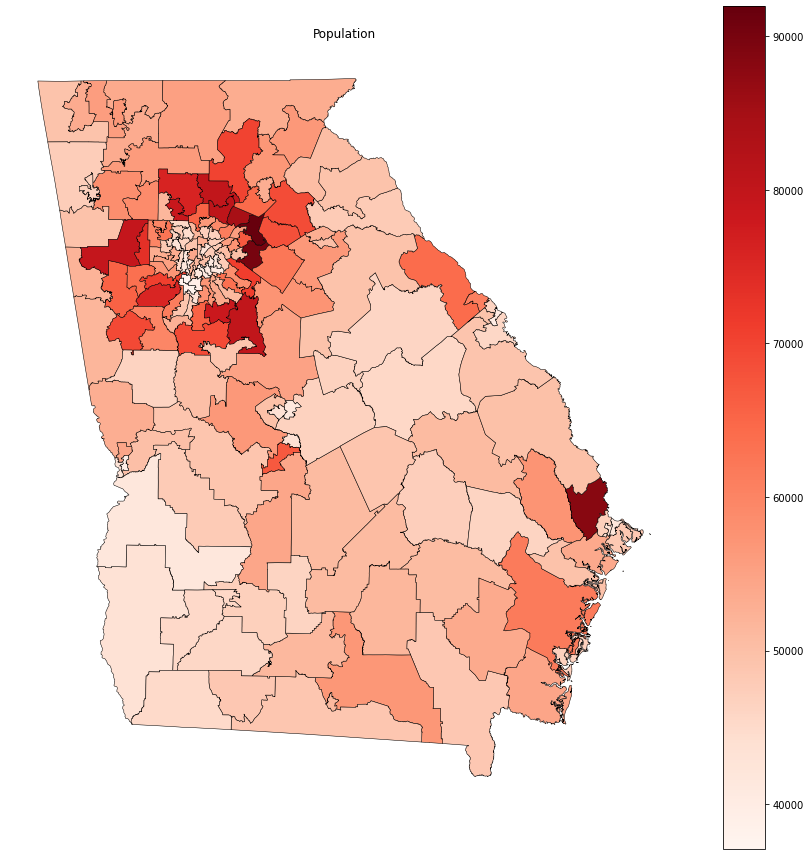

In [34]:
plot_column(df, 'TOTAL_sy', 'Population')

<AxesSubplot:title={'center':'Number of swaps'}>

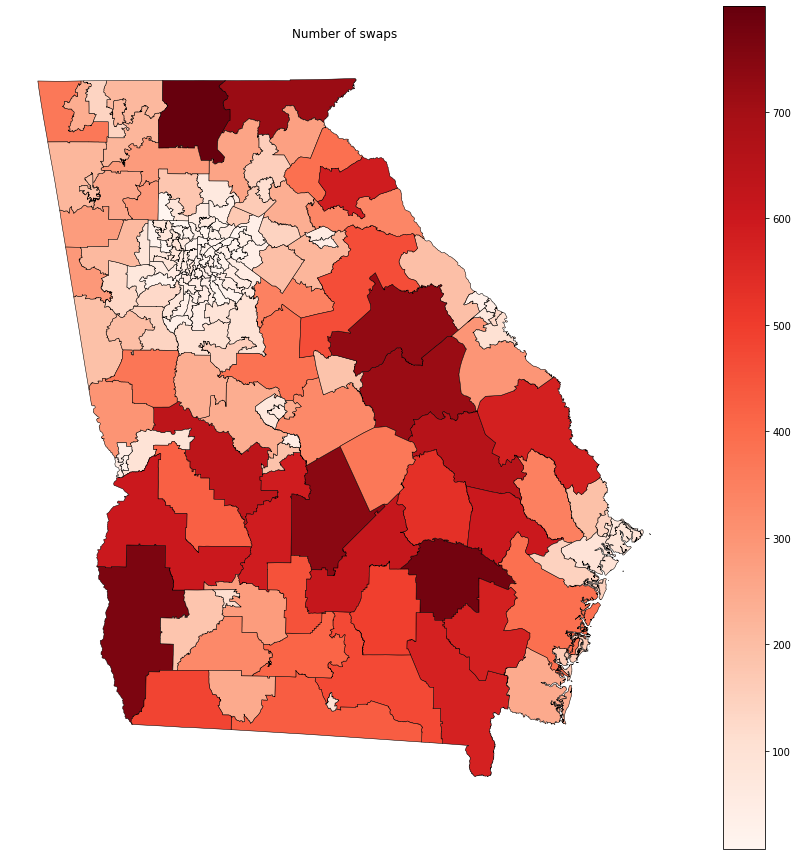

In [35]:
plot_column(df, 'swapped', 'Number of swaps')

## Race/ethnicity changes

In [36]:
def r_eth_changes(df):
    diffs = None
    r_eth_cols = ['W', 'B', 'AI_AN', 'AS', 'H_PI', 'OTH', 'TWO_OR_MORE', 'NUM_HISP']
    for c in r_eth_cols:
        if diffs is None:
            diffs = np.abs(df[c + '_sw'] - df[c + '_sy'])
        else:
            diffs += np.abs(df[c + '_sw'] - df[c + '_sy'])
    print('Total race/eth change across borders:', diffs.sum())
    c_name = 'r_eth_diff'
    df[c_name] = diffs
    plot_column(df, c_name, 'Change in race/eth counts')
    del df[c_name]

Total race/eth change across borders: 1248


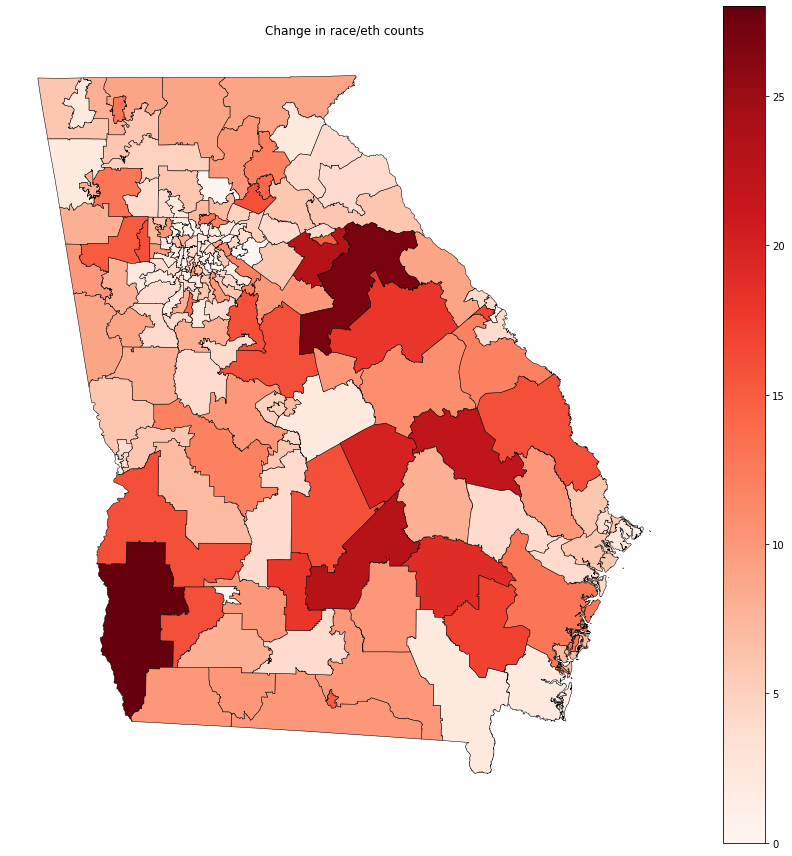

In [37]:
r_eth_changes(df)

In [38]:
def pct_white_changes(df):
    before_pct_white = df['W_sy'] / df['TOTAL_sy']
    after_pct_white = df['W_sw'] / df['TOTAL_sw']
    c_name = 'pct_white_change'
    df[c_name] = np.abs(after_pct_white - before_pct_white)
    plot_column(df, c_name, 'Change in fraction white')
    del df[c_name]

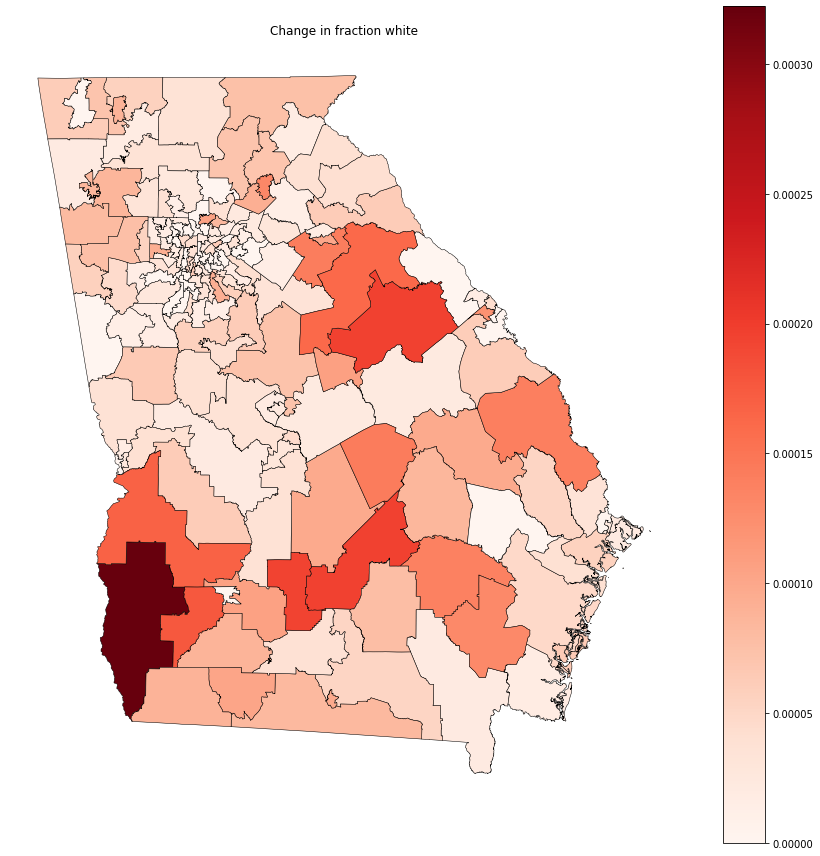

In [39]:
pct_white_changes(df)

## Racial analysis
Here, we look at the change in percent white at the voting district level (state lower and upper assemblies) as well as county and tract levels.

In [40]:
def pct_white_changes_stats(df, col):
    grouped = get_aggregated_df(df, col)
    print('There are', len(grouped), col + "'s")
    before_pct_white = grouped['W_sy'] / grouped['TOTAL_sy']
    after_pct_white = grouped['W_sw'] / grouped['TOTAL_sw']
    diff = after_pct_white - before_pct_white
    print('Largest absolute change in fraction white: {:.3g}'.format(np.max(np.abs(diff))))
    plt.figure()
    diff.plot.hist()
    plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    plt.title('Change in fraction white at ' + col)

In [42]:
levels = ['TRACTA', 'SLDLA', 'COUNTYA', 'SLDUA', 'CDA']

There are 1260 TRACTA's
Largest absolute change in fraction white: 0.5
There are 180 SLDLA's
Largest absolute change in fraction white: 0.000322
There are 159 COUNTYA's
Largest absolute change in fraction white: 0.00233
There are 56 SLDUA's
Largest absolute change in fraction white: 8.74e-05
There are 13 CDA's
Largest absolute change in fraction white: 1.73e-05


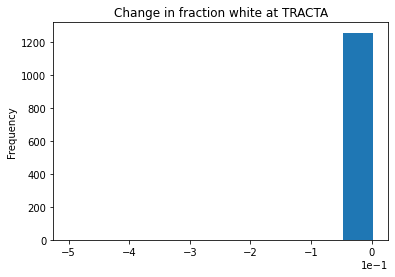

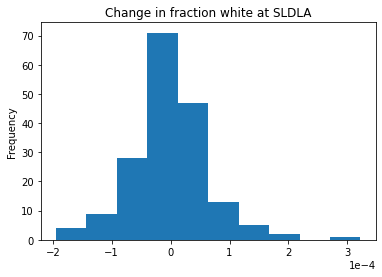

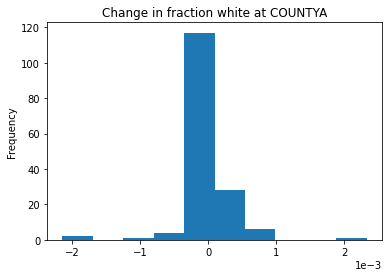

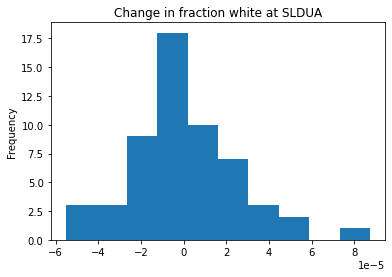

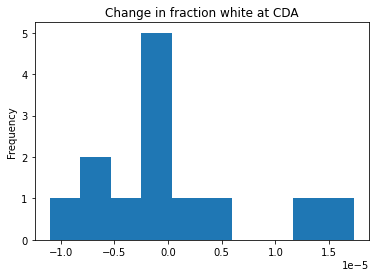

In [43]:
for level in levels:
    pct_white_changes_stats(orig_df, level)

## Majority minority district analysis
There are no MMDs in Vermont, so we wouldn't expect an effect here. But this code will be useful in the future.

In [44]:
def mmd_analysis(df, col):
    df = get_aggregated_df(df, col)
    before_mmd = df['W_sy'] / df['TOTAL_sy'] < .5
    after_mmd = df['W_sw'] / df['TOTAL_sw'] < .5
    change = before_mmd != after_mmd
    num_changes = change.sum()
    plt.figure()
    (df['W_sw'] / df['TOTAL_sw']).plot.hist(label=col)
    plt.title('Fraction white (swapped) ' + col)
    print('Number of MMD changes at', col, 'level:', num_changes, 'out of', len(df))

Number of MMD changes at TRACTA level: 1 out of 1260
Number of MMD changes at SLDLA level: 0 out of 180
Number of MMD changes at COUNTYA level: 0 out of 159
Number of MMD changes at SLDUA level: 0 out of 56
Number of MMD changes at CDA level: 0 out of 13


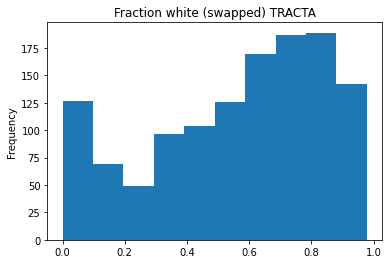

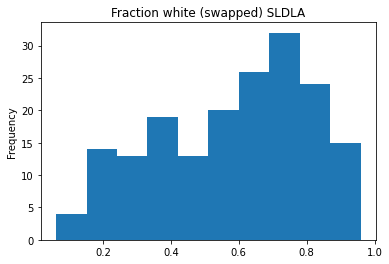

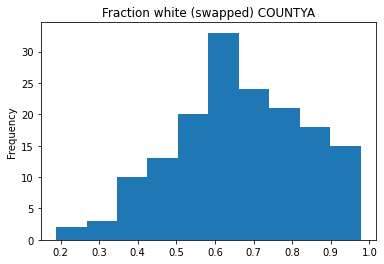

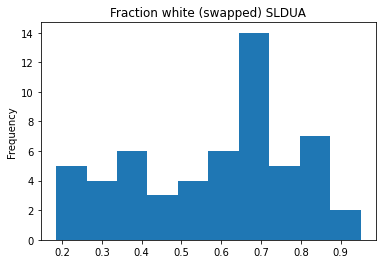

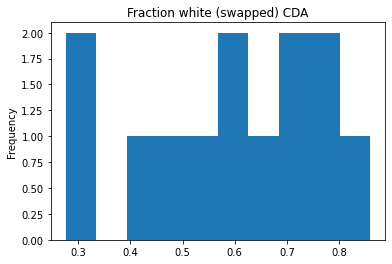

In [45]:
for level in levels:
    mmd_analysis(orig_df, level)

## Relationships to racial inaccuracy
We can look at the change in fraction white as a function of the population in the region in question (lower assembly district, upper assembly district, county, tract) and the fraction of the population that is white.

In [46]:
def add_pct_white(grouped):
    before_pct_white = grouped['W_sy'] / grouped['TOTAL_sy']
    after_pct_white = grouped['W_sw'] / grouped['TOTAL_sw']
    grouped['frac_white_change'] = after_pct_white - before_pct_white
    grouped['frac_white'] = before_pct_white

def plot_frac_white_relationships(df, col):
    grouped = get_aggregated_df(df, col)
    add_pct_white(grouped)
    grouped.plot.scatter(x='TOTAL_sy', y='frac_white_change')
    plt.title(col)
    grouped.plot.scatter(x='frac_white', y='frac_white_change')
    plt.title(col)
#     grouped['abs_white_change'] = np.abs(grouped['frac_white_change'])
#     grouped.plot.scatter(x='frac_white', y='abs_white_change')
#     plot_best_fit(grouped['frac_white'], grouped['abs_white_change'])
#     plt.title(col)

def plot_best_fit(x, y):
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

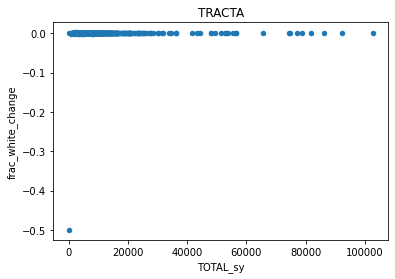

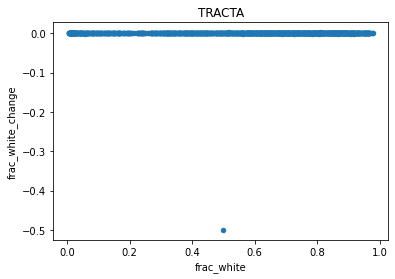

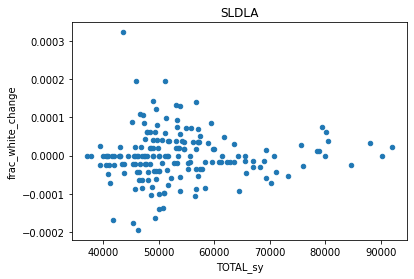

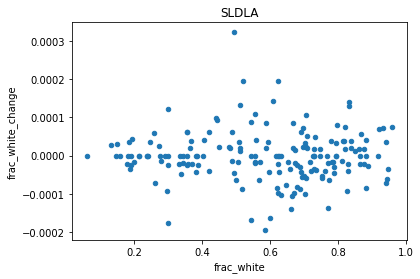

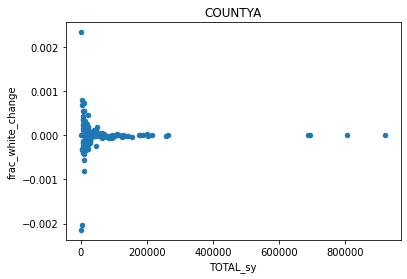

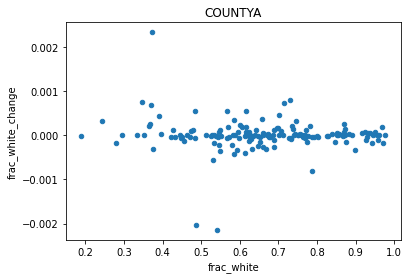

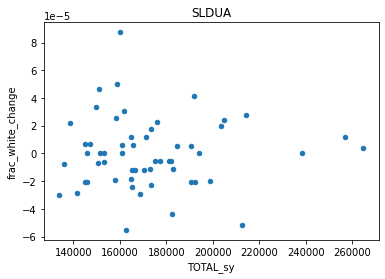

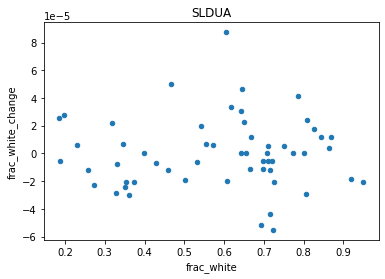

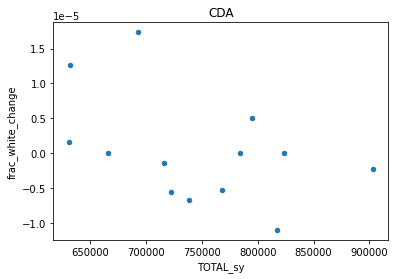

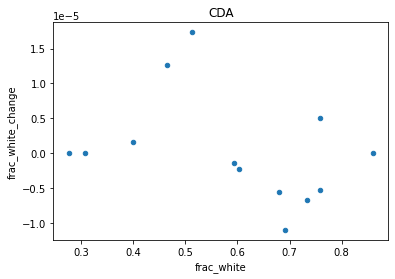

In [47]:
for level in levels:
    plot_frac_white_relationships(orig_df, level)

It appears that larger changes happen for very homogeneous areas. This is consistent with our intuition that swapping should occur where there are few minorities.

## Regression for number of swaps
Here, we regress number of swaps in a region over racial entropy. We can add in other dependent variables here as we go.

In [48]:
def add_entropy(df):
    r_cols = ['W', 'B', 'AI_AN', 'AS', 'H_PI', 'OTH', 'TWO_OR_MORE']
    r_cols = [c + '_sy' for c in r_cols]
    def before_entropy(row):
        ps = [row[c]/row['TOTAL_sy'] for c in r_cols]
        return sum(-p * np.log(p) for p in ps if p > 0)
    df['r_entropy'] = df.apply(before_entropy, axis=1)
    
def do_regression(df, col):
    grouped = get_aggregated_df(df, col)
    #add_pct_white(grouped)
    add_entropy(grouped)
    print(grouped.columns)
    X = grouped[['r_entropy']]
    Y = grouped['swapped']
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    print(model.summary())

In [49]:
do_regression(orig_df, 'SLDLA')

Index(['TOTAL_sw', 'W_sw', 'B_sw', 'AI_AN_sw', 'AS_sw', 'H_PI_sw', 'OTH_sw',
       'TWO_OR_MORE_sw', 'NUM_HISP_sw', '18_PLUS_sw', 'swapped', 'NUM_HH',
       'TOTAL_sy', 'W_sy', 'B_sy', 'AI_AN_sy', 'AS_sy', 'H_PI_sy', 'OTH_sy',
       'TWO_OR_MORE_sy', 'NUM_HISP_sy', '18_PLUS_sy', 'r_entropy'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                swapped   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     21.76
Date:                Sun, 27 Mar 2022   Prob (F-statistic):           6.04e-06
Time:                        16:29:17   Log-Likelihood:                -1197.3
No. Observations:                 180   AIC:                             2399.
Df Residuals:                     178   BIC:                             2405.
Df Model:                           1            

## Analyzing swapped pairs
Here, we try to get a sense for where swaps are occurring. How far is each swap? How many are within-region vs. across-region?

In [50]:
only_swaps = swapped_df[swapped_df['swapped'] == 1]
only_swaps.head()

,Unnamed: 0,YEAR,STATE,STATEA,COUNTYA,TRACTA,BLOCKA,BLOCK_TOTAL,BLOCK_18_PLUS,TOTAL,...,NUM_HISP,18_PLUS,HH_NUM,frequency,U,prob,blockid,household.id,swapped,id
0,0,2010,Georgia,13,153,21400,1040,1,1,1,...,1,1,0,102,4,1.0,021400-153-1034,021400-153-1040-0001,1,021400-153-1040
1,1,2010,Georgia,13,299,950200,3024,1,1,1,...,1,1,0,102,4,1.0,950200-299-3025,950200-299-3024-0000,1,950200-299-3024
2,2,2010,Georgia,13,23,790100,1101,1,1,1,...,0,1,0,268,4,1.0,790100-023-1102,790100-023-1101-0001,1,790100-023-1101
3,3,2010,Georgia,13,207,50102,2018,1,1,1,...,0,1,0,268,4,1.0,150100-035-4082,050102-207-2018-0001,1,050102-207-2018
4,4,2010,Georgia,13,63,40412,3020,1,1,1,...,0,1,0,268,4,1.0,040412-063-3031,040412-063-3020-0003,1,040412-063-3020


### Add geo data for source and destination blocks

In [51]:
def add_geos_from_blockid(df):
    block_df = block_df = pd.read_csv(get_block_file())
    block_df = block_df[['GISJOIN', 'COUNTYA', 'TRACTA', 'BLOCKA', 'SLDUA', 'SLDLA', 'CDA']]
    with_dest = df.merge(block_df,
                           how='inner',
                           on=['COUNTYA', 'TRACTA', 'BLOCKA'],
                           validate='many_to_one')
    make_identifier_synth(block_df)
    with_both = with_dest.merge(block_df,
                                  how='inner',
                                  left_on='blockid',
                                  right_on='id',
                                  suffixes=('_dest', '_source'),
                                  validate='many_to_one')
    map_dest = block_map.merge(with_both,
                            how='right',
                            left_on='GISJOIN',
                            right_on='GISJOIN_dest',
                            validate='one_to_many')
    del map_dest['GISJOIN_dest']
    map_both = block_map.merge(map_dest,
                               how='right',
                               left_on='GISJOIN',
                               right_on='GISJOIN_source',
                               suffixes=('_source', '_dest'),
                               validate='one_to_many')
    return map_both

In [52]:
swap_loc_df = add_geos_from_blockid(only_swaps)

In [53]:
swap_loc_df.head()

,STATEFP10_source,COUNTYFP10_source,TRACTCE10_source,BLOCKCE10_source,GEOID10_source,NAME10_source,MTFCC10_source,UR10_source,UACE10_source,UATYP10_source,...,SLDLA_dest,CDA_dest,GISJOIN_source,COUNTYA_source,TRACTA_source,BLOCKA_source,SLDUA_source,SLDLA_source,CDA_source,id_source
0,13,153,021400,1034,131530214001034,Block 1034,G5040,R,None,None,...,146,8,G13015300214001034,153,21400,1034,20,146,8,021400-153-1034
1,13,299,950200,3025,132999502003025,Block 3025,G5040,R,None,None,...,177,1,G13029909502003025,299,950200,3025,7,177,1,950200-299-3025
2,13,023,790100,1102,130237901001102,Block 1102,G5040,R,None,None,...,144,8,G13002307901001102,23,790100,1102,20,144,8,790100-023-1102
3,13,035,150100,4082,130351501004082,Block 4082,G5040,R,None,None,...,125,8,G13003501501004082,35,150100,4082,25,110,8,150100-035-4082
4,13,207,050102,2000,132070501022000,Block 2000,G5040,R,None,None,...,125,8,G13020700501022000,207,50102,2000,18,125,8,050102-207-2000


In [54]:
def add_distance(df):
    def dist(row):
        return float(distance.distance((row['INTPTLAT10_source'], row['INTPTLON10_source']), (row['INTPTLAT10_dest'], row['INTPTLON10_dest'])).miles)
    df['distance'] = df.apply(dist, axis=1)

In [55]:
add_distance(swap_loc_df)

In [56]:
def get_swap_lines(df):
    s_pts = gpd.points_from_xy(df['INTPTLON10_source'], df['INTPTLAT10_source'])
    d_pts = gpd.points_from_xy(df['INTPTLON10_dest'], df['INTPTLAT10_dest'])
    lines = pd.Series([LineString([p1, p2]) for p1, p2 in zip(s_pts, d_pts)])
    return gpd.GeoDataFrame(geometry=lines, crs="EPSG:4326").to_crs("EPSG:3395")

In [57]:
swap_lines = get_swap_lines(swap_loc_df)

/usr/local/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Here are some basic statistics on the distance (in miles) for each swap.

Summary statistics for distance (miles):
count    33600.000000
mean         0.524108
std          0.801742
min          0.009794
25%          0.146595
50%          0.338060
75%          0.689774
max         38.316220
Name: distance, dtype: float64


array([[<AxesSubplot:title={'center':'distance'}>]], dtype=object)

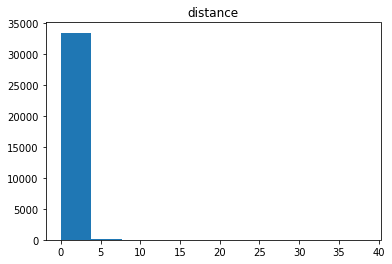

In [58]:
print('Summary statistics for distance (miles):')
print(swap_loc_df['distance'].describe())
swap_loc_df.hist(column=['distance'], grid=False)

We can also visualize the swapped pairs:

In [70]:
df['NUM_HH'].head()

0    19356
1    20705
2    20299
3    19267
4    18059
Name: NUM_HH, dtype: int64

<AxesSubplot:title={'center':'Number of swaps / HH'}>

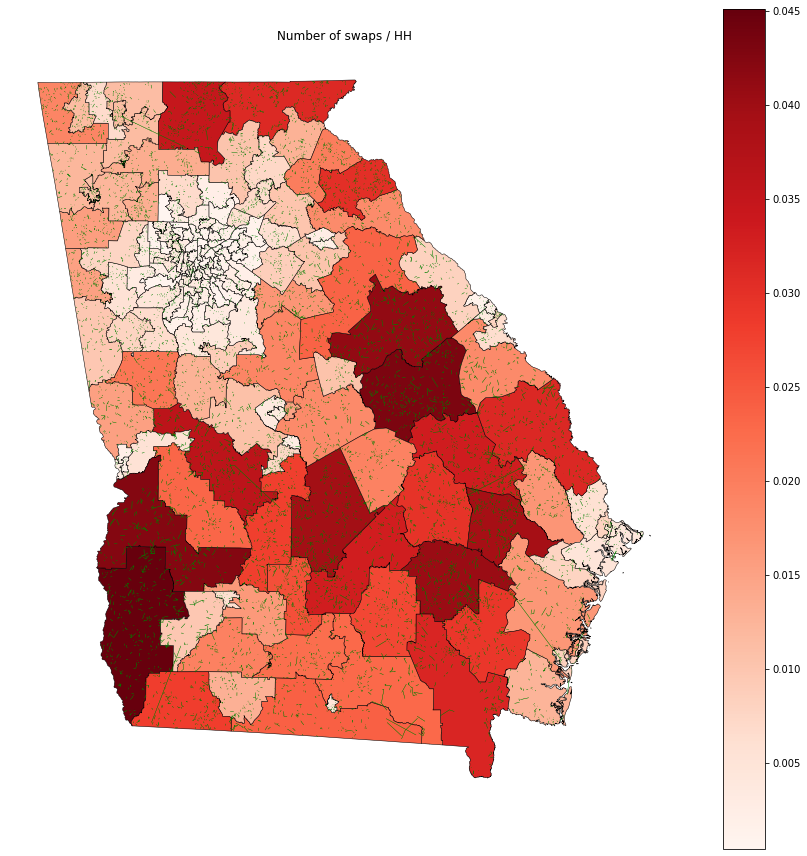

In [71]:
df['swapped_norm'] = df['swapped'] / df['NUM_HH']
ax = plot_column(df, 'swapped_norm', 'Number of swaps / HH')
swap_lines.plot(ax=ax, color='green', linewidth=.3)

Next, we can look at how many swaps cross the boundary of any given region

In [60]:
def boundary_crossing(df, col):
    c1 = col + '_source'
    c2 = col + '_dest'
    # Divide by 2 because each swap involves 2 households so it's double-counted
    num = (df[c1] != df[c2]).sum()/2
    tot = len(df)/2
    print('%s: %d out of %d (%.3f%%)' % (col, num, tot, num/tot*100))

In [61]:
for level in levels:
    boundary_crossing(swap_loc_df, level)

TRACTA: 1930 out of 16800 (11.488%)
SLDLA: 773 out of 16800 (4.601%)
COUNTYA: 678 out of 16800 (4.036%)
SLDUA: 414 out of 16800 (2.464%)
CDA: 205 out of 16800 (1.220%)


## Voting

In [62]:
vote_df = pd.read_csv("/Users/manish/Desktop/census_data/VT/voting/VT_Elections_Database__2008_President_General_Election_including_precincts.csv")

In [63]:
vote_df.head()

,City/Town,Ward,Pct,Barack Obama,John McCain,Ralph Nader,Bob Barr,Chuck Baldwin,Roger Calero,Gloria Lariva,Brian Moore,Write-Ins,Blanks,Spoiled,Total Votes Cast
0,NaN,NaN,NaN,Democratic,Republican,Independent,Libertarian,Constitution,Socialist Workers,Socialism and Liberation,Liberty Union,NaN,NaN,NaN,NaN
1,Addison,NaN,NaN,378,374,4,3,2,0,0,0,6,0.0,0.0,767
2,Albany,NaN,NaN,316,163,4,0,2,0,1,0,3,0.0,0.0,489
3,Alburgh,NaN,NaN,600,375,16,0,1,0,0,1,3,0.0,0.0,996
4,Andover,NaN,NaN,189,120,3,1,0,0,0,0,1,0.0,0.0,314


In [64]:
len(vote_df)

275

Note: matching voting data with census blocks seems like it'll be a bit difficult, so I'll hold off on this until we decide where we want to do this analysis and what data we'll be using.